In [2]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [3]:
data = pd.read_csv("PL 23-24 WS Events.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [4]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [5]:
data = add_carries(data)

In [6]:
data_carries = data[data['type'] == 'Carry']

In [7]:
data_passes = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful')]

In [8]:
left_halfspace_x_min = 60
left_halfspace_x_max = 60 + 42
left_halfspace_y_min = 50
left_halfspace_y_max = 50 + 12

right_halfspace_x_min = 60
right_halfspace_x_max = 60 + 42
right_halfspace_y_min = 18
right_halfspace_y_max = 18 + 12

# Add columns to identify half-space passes and carries
data_passes['in_rhs'] = (data_passes['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                         data_passes['y'].between(right_halfspace_y_min, right_halfspace_y_max))
data_passes['in_lhs'] = (data_passes['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                         data_passes['y'].between(left_halfspace_y_min, left_halfspace_y_max))
data_passes['into_rhs'] = (data_passes['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                           data_passes['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
                           (data_passes['in_rhs'] == False))
data_passes['into_lhs'] = (data_passes['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                           data_passes['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
                           (data_passes['in_lhs'] == False))

data_carries['in_rhs'] = (data_carries['x'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                          data_carries['y'].between(right_halfspace_y_min, right_halfspace_y_max))
data_carries['in_lhs'] = (data_carries['x'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                          data_carries['y'].between(left_halfspace_y_min, left_halfspace_y_max))
data_carries['into_rhs'] = (data_carries['endX'].between(right_halfspace_x_min, right_halfspace_x_max) & 
                            data_carries['endY'].between(right_halfspace_y_min, right_halfspace_y_max) & 
                            (data_carries['in_rhs'] == False))
data_carries['into_lhs'] = (data_carries['endX'].between(left_halfspace_x_min, left_halfspace_x_max) & 
                            data_carries['endY'].between(left_halfspace_y_min, left_halfspace_y_max) & 
                            (data_carries['in_lhs'] == False))

# Filter data for passes and carries into half-spaces
rhs_passes = data_passes[data_passes['into_rhs']]
lhs_passes = data_passes[data_passes['into_lhs']]
rhs_carries = data_carries[data_carries['into_rhs']]
lhs_carries = data_carries[data_carries['into_lhs']]

# Group and aggregate
rhs_passes_grouped = rhs_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='rhs_passes')
lhs_passes_grouped = lhs_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='lhs_passes')
rhs_carries_grouped = rhs_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='rhs_carries')
lhs_carries_grouped = lhs_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='lhs_carries')

result_df_rhs = pd.merge(rhs_passes_grouped, rhs_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
result_df_rhs['rhs_actions'] = result_df_rhs['rhs_passes'] + result_df_rhs['rhs_carries']

result_df_lhs = pd.merge(lhs_passes_grouped, lhs_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
result_df_lhs['lhs_actions'] = result_df_lhs['lhs_passes'] + result_df_lhs['lhs_carries']

# Merge with player metadata (e.g., minutes played)
info = pd.read_csv("T5 Leagues Mins 23-24.csv")
info['90s'] = info['Mins'] / 90

result_df_rhs = pd.merge(result_df_rhs, info, on=['player', 'team'], how='left')
result_df_rhs['rhs_act_p90'] = result_df_rhs['rhs_actions'] / result_df_rhs['90s']
result_df_rhs = result_df_rhs[(result_df_rhs['90s'] >= 15) & (result_df_rhs['position'] != 'GK')]

result_df_lhs = pd.merge(result_df_lhs, info, on=['player', 'team'], how='left')
result_df_lhs['lhs_act_p90'] = result_df_lhs['lhs_actions'] / result_df_lhs['90s']
result_df_lhs = result_df_lhs[(result_df_lhs['90s'] >= 15) & (result_df_lhs['position'] != 'GK')]

top_12_rhs = result_df_rhs.sort_values("rhs_act_p90", ascending=False).head(12)
top_12_lhs = result_df_lhs.sort_values("lhs_act_p90", ascending=False).head(12)




/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_37419/3811895442.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes['in_rhs'] = (data_passes['x'].between(right_halfspace_x_min, right_halfspace_x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_37419/3811895442.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes['in_lhs'] = (data_passes['x'].between(left_halfspace_x_min, left_halfspace_x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_3

In [9]:
top_12_lhs

,playerId,player,team,lhs_passes,lhs_carries,lhs_actions,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,lhs_act_p90
62,93894.0,Mateo Kovacic,Man City,126.0,88.0,214.0,212.0,30.0,M(CL),1549.0,94.1,17.211111,12.433828
429,402664.0,Josko Gvardiol,Man City,230.0,76.0,306.0,47.0,22.0,D(CL),2330.0,88.3,25.888889,11.819742
215,303139.0,Rodri,Man City,243.0,102.0,345.0,1.0,28.0,"D(C),DMC",2937.0,92.5,32.633333,10.572012
385,382241.0,Igor Julio,Brighton,113.0,63.0,176.0,281.0,26.0,"D(CL),M(L)",1638.0,93.6,18.200000,9.670330
188,273257.0,Oleksandr Zinchenko,Arsenal,109.0,69.0,178.0,115.0,27.0,"D(L),M(CLR)",1727.0,89.4,19.188889,9.276202
395,388098.0,Jérémy Doku,Man City,122.0,42.0,164.0,17.0,22.0,M(LR),1596.0,86,17.733333,9.248120
115,122945.0,Nathan Aké,Man City,130.0,72.0,202.0,156.0,29.0,"D(CL),DMC",2044.0,92.8,22.711111,8.894325
381,380706.0,Gabriel Martinelli,Arsenal,150.0,31.0,181.0,72.0,23.0,"AM(LR),FW",2031.0,85,22.566667,8.020679
383,381255.0,Billy Gilmour,Brighton,127.0,53.0,180.0,355.0,23.0,DMC,2126.0,92.2,23.622222,7.619944
40,79583.0,Tom Cairney,Fulham,81.0,42.0,123.0,277.0,33.0,M(CR),1480.0,90.3,16.444444,7.479730


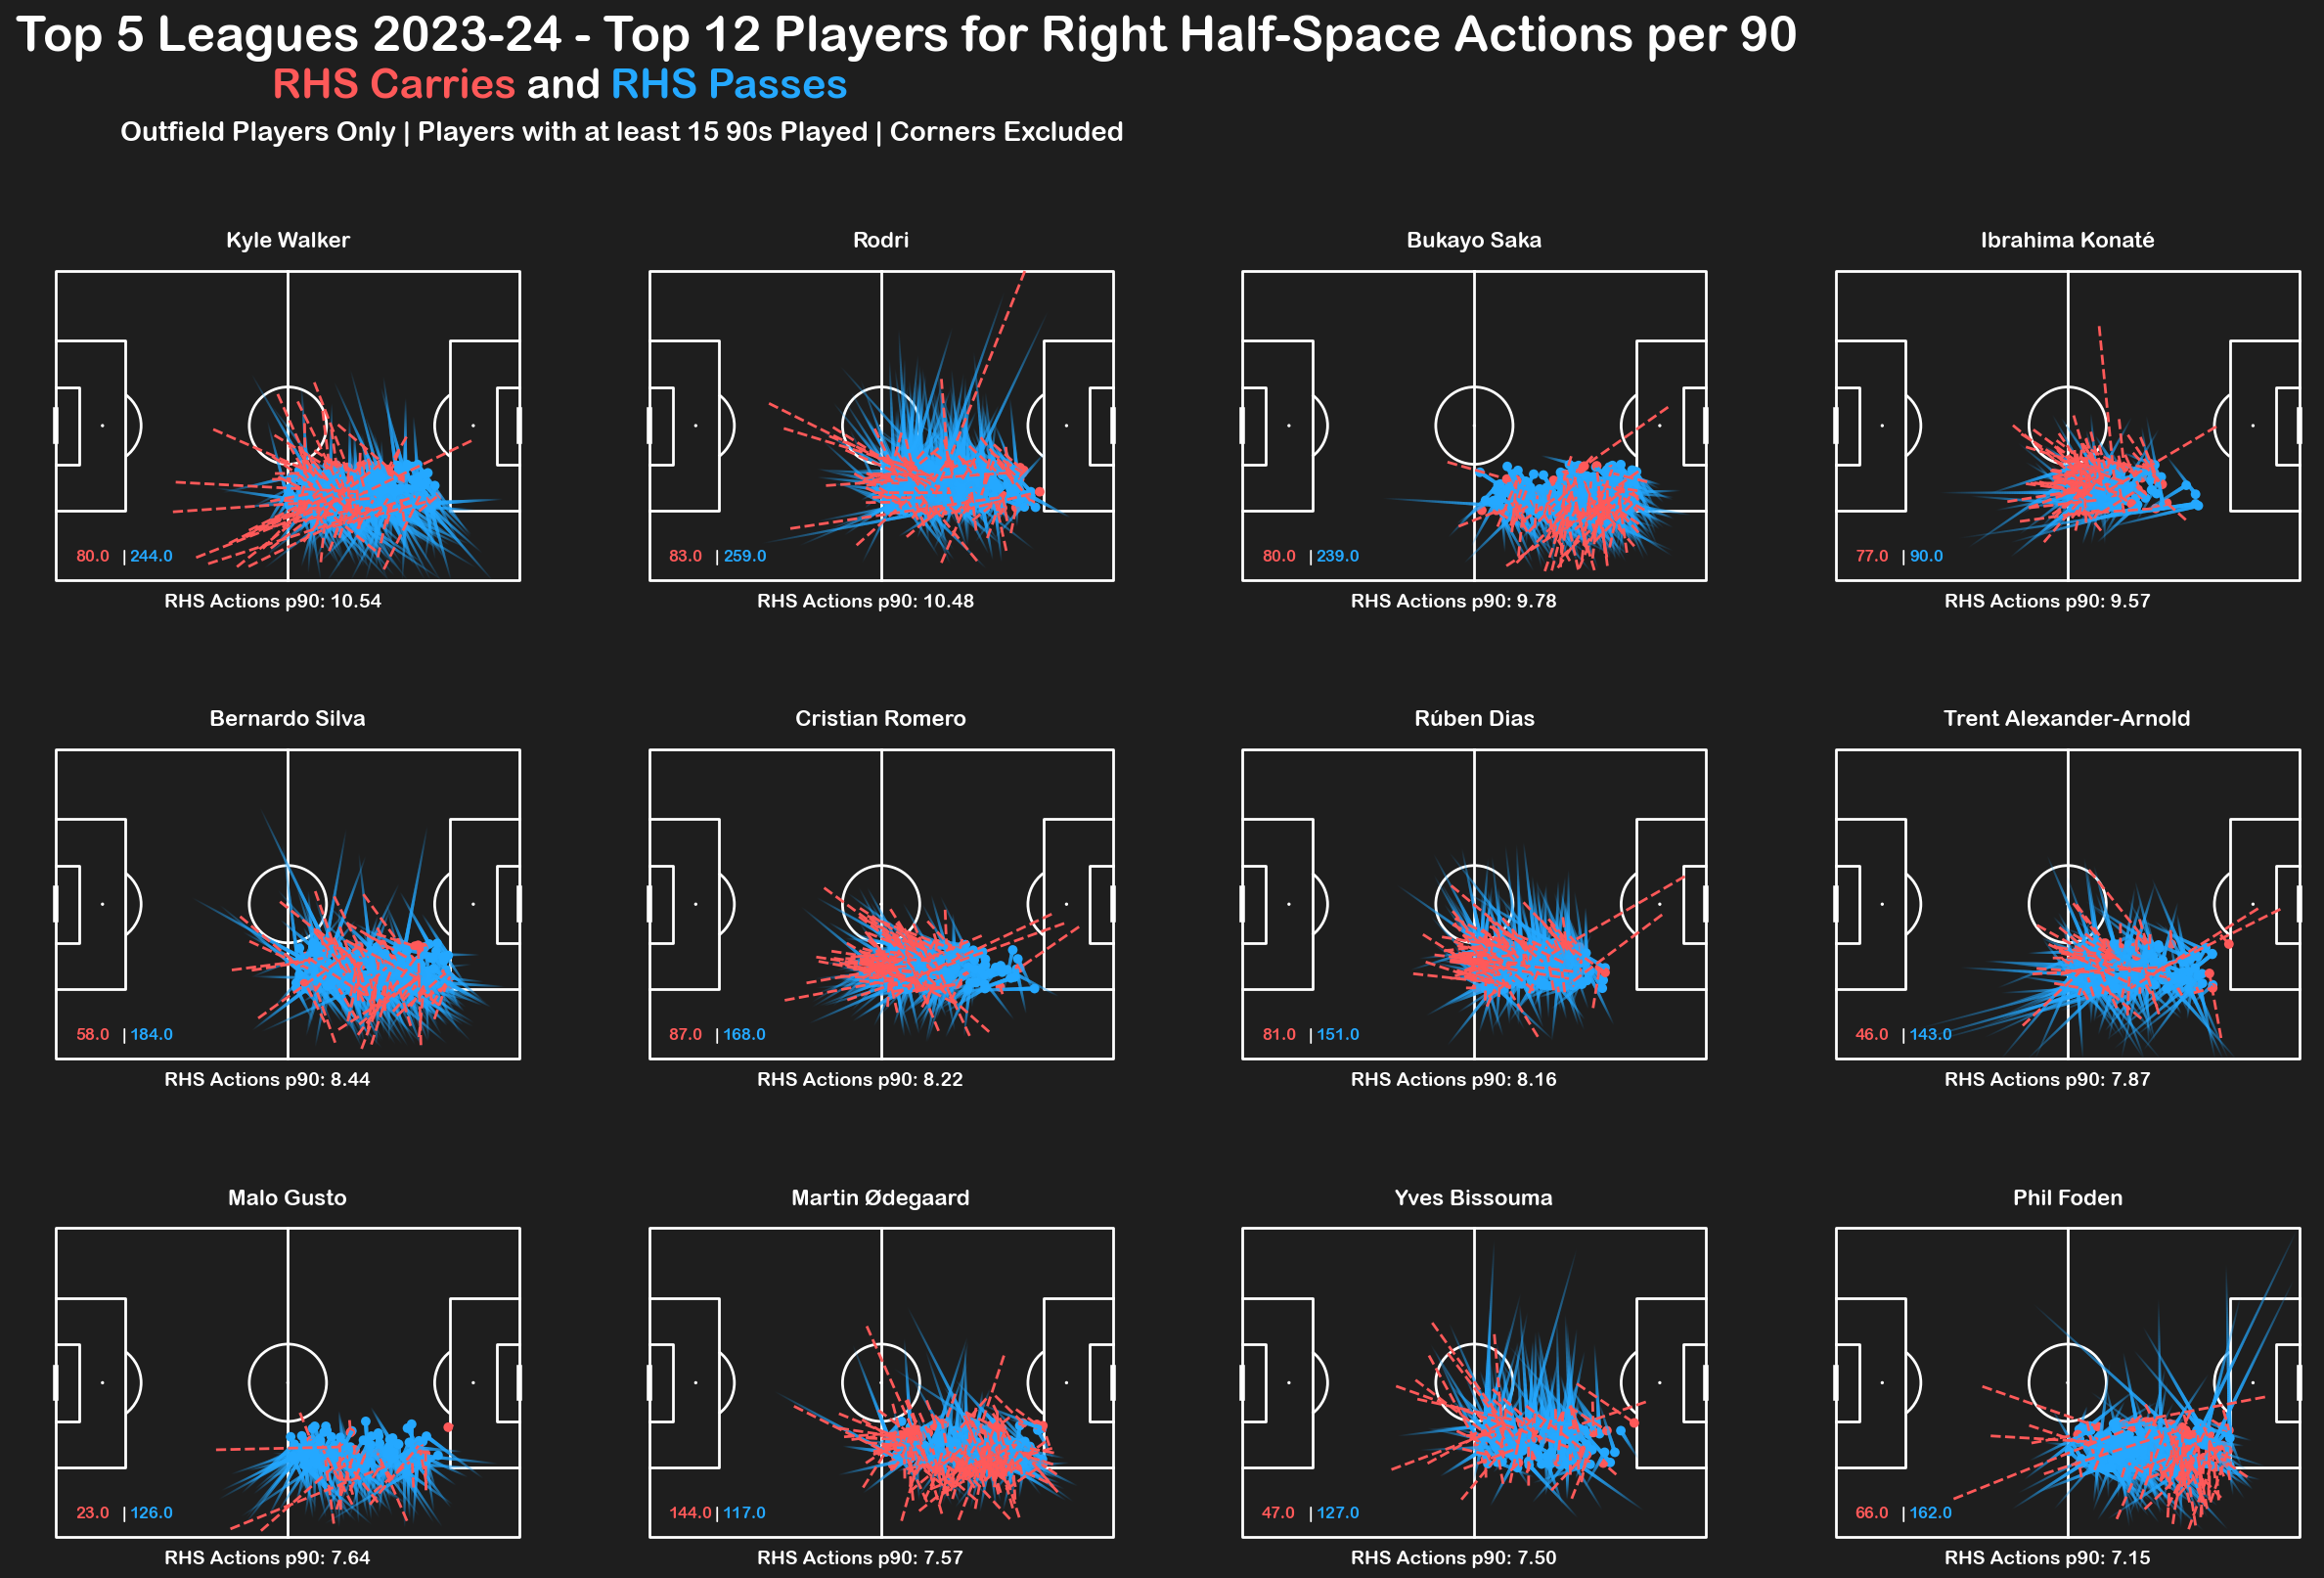

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

for ax, (_, player_data) in zip(axs.flatten(), top_12_rhs.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    rhs_passes_count = player_data['rhs_passes']
    rhs_carries_count = player_data['rhs_carries']
    rhs_act_p90 = player_data['rhs_act_p90']
    
    player_passes = rhs_passes[rhs_passes['playerId'] == player_id]
    player_carries = rhs_carries[rhs_carries['playerId'] == player_id]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot RHS Passes
    pitch.lines(player_passes.x, player_passes.y, player_passes.endX, player_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_passes.endX, player_passes.endY, s=50, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot RHS Carries
    pitch.lines(player_carries.x, player_carries.y, player_carries.endX, player_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_carries.endX, player_carries.endY, s=50, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    ax.text(5, 5, f'{rhs_carries_count}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(17, 5, '|', color='#FFFFFF', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(19, 5, f'{rhs_passes_count}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=12, ha='left')
    ax.text(28, -7, f'RHS Actions p90: {rhs_act_p90:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=14, ha='left')

fig_text(0.42, 1.00, "Top 5 Leagues 2023-24 - Top 12 Players for Right Half-Space Actions per 90", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.302, 0.97, "<RHS Carries> and <RHS Passes>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'}, {"color": '#24A8FF'}])
fig_text(0.323, 0.94, "Outfield Players Only | Players with at least 15 90s Played | Corners Excluded", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')